# Proyek Klasifikasi jerawat


## Import Semua Packages/Library yang Digunakan

In [2]:
# Install package tambahan (jika belum ada)
!pip install tensorflow tensorflowjs matplotlib

# Import semua library yang dibutuhkan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import pathlib
from google.colab import drive


## Data Preparation

### Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Gantilah path di bawah ini dengan lokasi direktori dataset di GDrive kamu
dataset_path = '/content/drive/MyDrive/dataset_jerawat'

Mounted at /content/drive


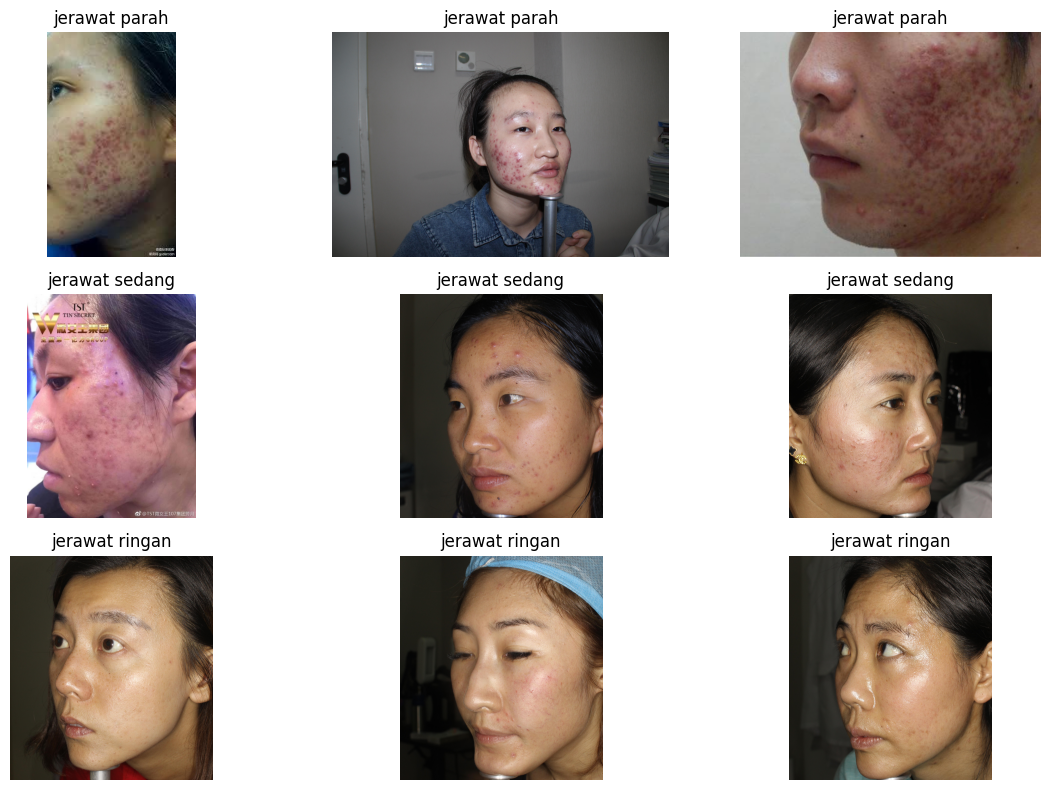

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ganti dengan path dataset kamu di Google Drive
dataset_dir = '/content/drive/MyDrive/dataset_jerawat'

# Menampilkan beberapa gambar dari masing-masing kelas
kelas = os.listdir(dataset_dir)
plt.figure(figsize=(12, 8))

i = 1
for label in kelas:
    folder = os.path.join(dataset_dir, label)
    images = os.listdir(folder)[:3]  # ambil 3 gambar pertama
    for img_name in images:
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(len(kelas), 3, i)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()


In [6]:
import os

# Ganti dengan path ke folder dataset kamu di Google Drive
dataset_dir = '/content/drive/MyDrive/dataset_jerawat'

# Cek kelas (folder dalam dataset)
kelas = os.listdir(dataset_dir)
print("Daftar Kelas:")
print(kelas)

# Tampilkan jumlah gambar dalam setiap kelas
for k in kelas:
    folder = os.path.join(dataset_dir, k)
    if os.path.isdir(folder):
        jumlah = len(os.listdir(folder))
        print(f"{k}: {jumlah} gambar")


Daftar Kelas:
['jerawat parah', 'jerawat sedang', 'jerawat ringan']
jerawat parah: 137 gambar
jerawat sedang: 186 gambar
jerawat ringan: 1134 gambar


### Data Preprocessing

#### Split Dataset

In [7]:
# Ukuran gambar dan batch size
img_size = (224, 224)
batch_size = 32

# Asumsikan base_dir sama dengan dataset_dir yang sudah ada
base_dir = dataset_dir


In [8]:
import os
import shutil
import random

# Ganti dengan path ke folder dataset kamu di Google Drive
dataset_dir = '/content/drive/MyDrive/dataset_jerawat'

# Tentukan path baru untuk menyimpan dataset yang sudah di-split
split_base_dir = '/content/drive/MyDrive/dataset_jerawat_split'

# Tentukan rasio split (contoh: 80% train, 10% val, 10% test)
split_ratio = {'train': 0.8, 'val': 0.1, 'test': 0.1}

# Pastikan directory split base ada dan kosongkan jika perlu
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)
os.makedirs(split_base_dir)

# Dapatkan daftar kelas (folder) dari dataset asli
kelas = os.listdir(dataset_dir)
print("Kelas yang ditemukan:", kelas)

# Buat direktori train, val, dan test untuk setiap kelas
for split_type in split_ratio.keys():
    split_dir = os.path.join(split_base_dir, split_type)
    os.makedirs(split_dir, exist_ok=True) # pastikan direktori dasar split ada
    for k in kelas:
        os.makedirs(os.path.join(split_dir, k), exist_ok=True)

# Iterasi melalui setiap kelas dan lakukan split data
for k in kelas:
    class_dir = os.path.join(dataset_dir, k)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        random.shuffle(images) # Acak urutan gambar

        total_images = len(images)
        train_count = int(total_images * split_ratio['train'])
        val_count = int(total_images * split_ratio['val'])
        # Test count akan mengambil sisa gambar
        test_count = total_images - train_count - val_count

        train_images = images[:train_count]
        val_images = images[train_count : train_count + val_count]
        test_images = images[train_count + val_count :]

        print(f"\nProcessing class: {k}")
        print(f"Total images: {total_images}")
        print(f"Train images: {len(train_images)}")
        print(f"Validation images: {len(val_images)}")
        print(f"Test images: {len(test_images)}")

        # Pindahkan gambar ke folder yang sesuai
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(split_base_dir, 'train', k, img)
            shutil.copy(src, dst)

        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(split_base_dir, 'val', k, img)
            shutil.copy(src, dst)

        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(split_base_dir, 'test', k, img)
            shutil.copy(src, dst)

print("\nData berhasil di-split dan disalin!")

# Setelah menjalankan script di atas, ubah path base_dir
# untuk menunjuk ke direktori yang sudah di-split
base_dir = split_base_dir


Kelas yang ditemukan: ['jerawat parah', 'jerawat sedang', 'jerawat ringan']

Processing class: jerawat parah
Total images: 137
Train images: 109
Validation images: 13
Test images: 15

Processing class: jerawat sedang
Total images: 186
Train images: 148
Validation images: 18
Test images: 20

Processing class: jerawat ringan
Total images: 1134
Train images: 907
Validation images: 113
Test images: 114

Data berhasil di-split dan disalin!


In [9]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1164 images belonging to 3 classes.
Found 144 images belonging to 3 classes.
Found 149 images belonging to 3 classes.


## Modelling

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,082,499 (99.50 MB)

 Trainable params: 26,081,539 (99.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('model_best.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [13]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, lr_schedule]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7100 - loss: 12.5912
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to model_best.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7095 - loss: 12.5186 - val_accuracy: 0.7778 - val_loss: 2.7693 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7312 - loss: 4.7646
Epoch 2: val_accuracy improved from 0.77778 to 0.78472, saving model to model_best.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7311 - loss: 4.7394 - val_accuracy: 0.7847 - val_loss: 2.0465 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7429 - loss: 1.6884
Epoch 3: val_accuracy did not improve from 0.78472
37/37 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7431 - loss: 1.6843 - val_accuracy: 0.7778 - val_loss: 1.1547 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8013 - loss: 0.7173
Epoch 4: val_accuracy did not improve from 0.78472
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8013 - loss: 0.7161 - val_accuracy: 0.7708 - val_loss: 1.0630 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8425 - loss: 0.5232
Epoch 5: val_accuracy did not improve from 0.78472
37/37 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8420 - loss: 0.5249 - val_accuracy: 0.7500 - val_loss: 0.9612 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 

37/37 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8411 - loss: 0.4165 - val_accuracy: 0.7917 - val_loss: 1.0880 - learning_rate: 5.0000e-04
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8402 - loss: 0.4056
Epoch 13: val_accuracy did not improve from 0.79167
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8405 - loss: 0.4050 - val_accuracy: 0.7917 - val_loss: 1.2439 - learning_rate: 5.0000e-04
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


## Evaluasi dan Visualisasi

In [14]:
# Evaluasi performa model terhadap data test
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7981 - loss: 0.7276

Test Accuracy: 0.7718
Test Loss: 0.7732


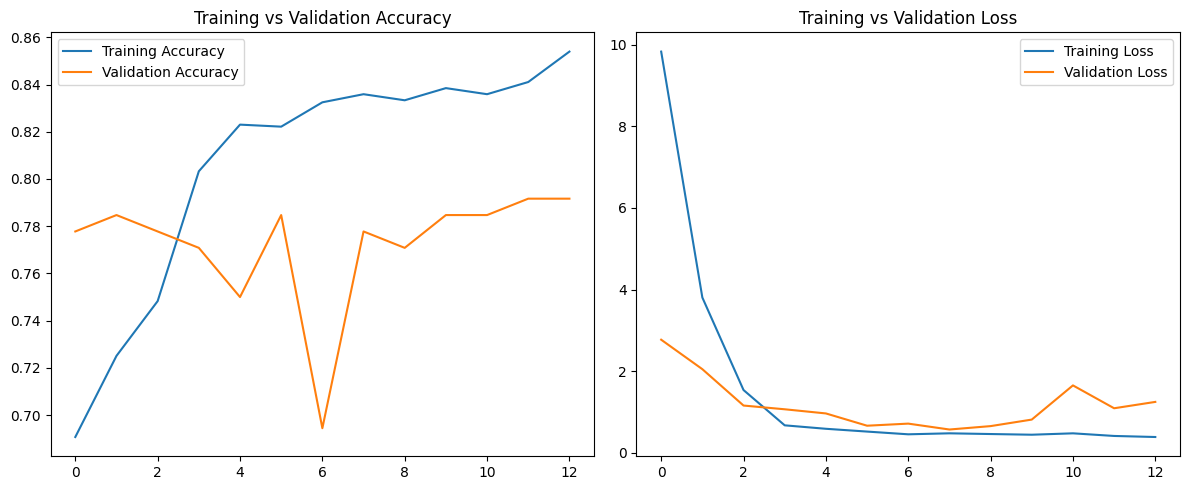

In [15]:
import matplotlib.pyplot as plt

# Ambil seluruh data history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Buat plot akurasi & loss
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Konversi Model

In [16]:
model.save('model_jerawat.h5')


In [17]:
model.export('model_jerawat_savedmodel')


Saved artifact at 'model_jerawat_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139257264814608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257264815952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257264815184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257167250832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257264812688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257264815376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257167251216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257167252752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257167253136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257167251024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257

In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_jerawat_savedmodel')
tflite_model = converter.convert()

with open('model_jerawat.tflite', 'wb') as f:
    f.write(tflite_model)


In [19]:
# !pip install tensorflowjs

!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    model_jerawat_savedmodel model_jerawat_tfjs

2025-05-27 03:51:18.861483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748317878.882244   12114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748317878.888227   12114 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-27 03:51:25.326581: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748317885.326782   12114 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
target_folder = '/content/drive/MyDrive/model_jerawat_final'


In [22]:
import os
import shutil

# Tentukan path target folder di Google Drive
target_folder = '/content/drive/MyDrive/model_jerawat_final'

# 🛠️ PERBAIKAN 1: Cek apakah path sudah ada dan merupakan FILE, bukan folder
if os.path.exists(target_folder) and os.path.isfile(target_folder):
    print(f"⚠️ Path {target_folder} sudah ada dan merupakan file. Menghapus...")
    os.remove(target_folder)  # Hapus file tersebut

# 🛠️ PERBAIKAN 2: Sekarang aman membuat folder target
os.makedirs(target_folder, exist_ok=True)

# 🛠️ PERBAIKAN 3: Buat path untuk folder SavedModel dan TFJS di dalam target folder
savedmodel_target = os.path.join(target_folder, 'model_jerawat_savedmodel')
tfjs_target = os.path.join(target_folder, 'model_jerawat_tfjs')

# 🧹 Jika subfolder sudah ada, bersihkan dulu untuk menghindari FileExistsError
for folder in [savedmodel_target, tfjs_target]:
    if os.path.exists(folder):
        if os.path.isdir(folder):
            shutil.rmtree(folder)  # Hapus folder
        else:
            os.remove(folder)      # Hapus file

# ✅ Salin file model utama (.h5 dan .tflite)
shutil.copy('model_jerawat.h5', target_folder)
shutil.copy('model_best.h5', target_folder)
shutil.copy('model_jerawat.tflite', target_folder)

# ✅ Salin folder SavedModel dan TFJS ke Google Drive
shutil.copytree('model_jerawat_savedmodel', savedmodel_target)
shutil.copytree('model_jerawat_tfjs', tfjs_target)

print("✅ Semua file dan folder model berhasil disalin ke Google Drive!")


✅ Semua file dan folder model berhasil disalin ke Google Drive!
